### Building an Image Classifier
- Start with Sequential API to classify and regress (declarative model i.e. we outline the structure of layers upfont)
- then Functional API model (declarative) where each layer is a function on some other layer (not in sequence), with one o many inputs (if we want to split some featues and tain them diffeently), on or many outputs (if we want to have multiple outputs, one for each task, or to regularize model with an auxiliary output to prevent overfitting)
- then Subclassing API to build Dynamic Models (not declarative) - if we need to loop, or if-statement to connect layers in a dynamic way. Very flexible but difficult to track errors, save or clone
- Also, Models can be combined! - each model can be treated just as an ordinary layer and connected with others to form a chain or a super model

<img src="screenshots/ch_11/2023-01-24-19-51-57.png" width="600px" img/>
<img src="screenshots/ch_10/2023-01-24-19-49-07.png" width="600px" img/>
<img src="screenshots/ch_10/2023-01-24-19-55-52.png" width="600px" img/>

<img src="screenshots/ch_10/2023-01-24-19-56-39.png" width="600px" img/>

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
import tensorflow as tf
from tensorflow import keras

In [106]:
print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
# if SSL errror: I came across this problem as well. I did some digging and found that the problem was that I didn't have the right certificates installed for Python3. Fairly easy fix on a Mac - run the file located at Applications>Python 3.X>Install Certificates.command and that should do the trick.

print(type(X_train_full),X_train_full.shape)

# each pic is 28x28 pixels i.e. 28 rows with 28 elements in each row:
print(X_train_full[:2])
#Each pixel intensity is represented as a byte (0 to 255):
print(X_train_full.dtype)
print(X_train_full.min(),X_train_full.max())

#The labels are the class IDs (represented as uint8), from 0 to 9:
print(type(y_train_full),y_train_full.shape, y_train_full.dtype)
print(y_train_full)

# Here are the corresponding class names:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]



<class 'numpy.ndarray'> (60000, 28, 28)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
uint8
0 255
<class 'numpy.ndarray'> (60000,) uint8
[9 0 0 ... 3 0 5]


Let's split the full training set into a validation set and a (smaller) training set. 
We also scale (a must for NNs) the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [108]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

Coat


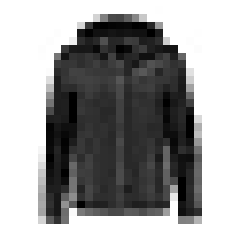

In [109]:
image_to_show=0

print(class_names[y_train[image_to_show]])

plt.imshow(X_train[image_to_show], cmap="binary")
plt.axis('off')
plt.show()

sample of images

Saving figure fashion_mnist_plot


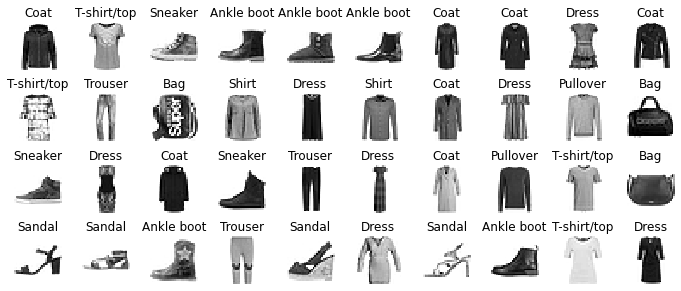

In [110]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

### Classifiction model using Sequential API
- declarative model i.e. each layer needs to be declared in advance
- single stack of layers connected sequentially

<img src="screenshots/ch_10/2023-01-24-19-54-11.png" width="600px" img/>
<img src="screenshots/ch_10/2023-01-24-19-58-56.png" width="600px" img/>

In [111]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) #converts images to "flat" 1D array

# 1st Dense Hidden layer of 300 neurons with "relu" activation.
# layer has it's own weight matrix connecting intputs to neutrons. also a vector of bias terms (one per neutron)
# it calculates the intial value for each weight (with random start)
model.add(keras.layers.Dense(300, activation="relu")) 

# 2nd Dense Hidden layer of 100 neurons with "relu" activation (more aggregated). same logic as above
model.add(keras.layers.Dense(100, activation="relu"))

# Final Dense Output layer with 10 neurons - one per target class
# Uses Softmax activation function because classes are exclusive
model.add(keras.layers.Dense(10, activation="softmax"))

### Succinct syntax:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

print('model layers', model.layers)
print(model.layers[1])
print(model.layers[1].name)


model layers [<keras.layers.reshaping.flatten.Flatten object at 0x1609cbbe0>, <keras.layers.core.dense.Dense object at 0x1609bc4a8>, <keras.layers.core.dense.Dense object at 0x1609bc5c0>, <keras.layers.core.dense.Dense object at 0x160a10e80>]
dense_15


In [112]:
## Show inital weights
weights, biases = model.layers[1].get_weights()

print ("weights",weights.shape,weights.sum(),weights) # random
print ("biases",biases.shape,biases) # all set to 0 initially

weights (784, 300) 6.6012087 [[-0.02123968 -0.02596946  0.05954324 ... -0.06106606 -0.07166125
  -0.03965411]
 [ 0.04891162  0.00478305 -0.07241608 ...  0.04798203 -0.04831857
  -0.05488206]
 [ 0.02345052 -0.07059563 -0.0727627  ...  0.0288062   0.06374887
   0.05407514]
 ...
 [-0.06780811 -0.01886623 -0.02003569 ... -0.0389171   0.07255684
  -0.05953335]
 [ 0.04758119  0.01428352  0.03311343 ...  0.05484565 -0.068021
   0.00730271]
 [-0.06452577  0.025761    0.07059865 ... -0.02975474 -0.00177423
  -0.01088178]]
biases (300,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Model summary

In [113]:
model.summary()
# flatten input: 28 x 28 = 784
# each input is connected to each neuron in first layer: 784 x 300 + 300 bias vector = 235500 etc.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 300)               235500    
                                                                 
 dense_16 (Dense)            (None, 100)               30100     
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


##### Compile the model
- compile to specify Loss Function and Optimizer, list of Metrics to use
- "sparse_categorical_crossentropy" - because we have sparse target labels i.e. one label per class
    - if it was a prob vector per class e.g. [0,0,0,...1,..0,0] - one-hot vector with 1 out 10 = 1 else 0 - we would use "categorical_crossentropy" (to convert from one-hot to sparse: keras.utils.to_categorical(), sparse to one-hot vector: np.argmax(axis=1))
    - if we were using Binary classification - would use "sigmoid" activation function and loss="binary_crossentropy"

- optimizer="sgd" - stochastic gradient decent



In [114]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## equivalent to
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(), # with this syntax we need to specify learning rate lr= ?
              metrics=[keras.metrics.sparse_categorical_accuracy])

##### Train Model
- if the y_train classes are very skewed, we can pass "class_weight" arg. -> would be used to compute loss
- per instance weight can be passed- "sample_weight" e.g. if some instance were labeled by experiement, while other by algo (we can give more weight to them)
- we can add "sample_weight" to validation -> validation_data=(Xval,Yval,"sample_weight")

In [115]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7275 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.5272 - val_sparse_categorical_accuracy: 0.8200
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4914 - sparse_categorical_accuracy: 0.8287 - val_loss: 0.4382 - val_sparse_categorical_accuracy: 0.8528
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4443 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.5311 - val_sparse_categorical_accuracy: 0.8008
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.3942 - val_sparse_categorical_accuracy: 0.8640
Epoch 5/30
 774/1719 [============>.................] - ETA: 1s - loss: 0.4067 - sparse_categorical_accuracy: 0.8578

KeyboardInterrupt: 

In [ ]:
print("history.params",history.params)
print("history.epoch",history.epoch)
print("history.history.keys()",history.history)
print("history.history.keys()",history.history.keys())

history.params {'verbose': 1, 'epochs': 30, 'steps': 1719}
history.epoch [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
history.history.keys() {'loss': [0.7159741520881653, 0.4880833923816681, 0.44382816553115845, 0.4171428680419922, 0.3967849016189575, 0.38106757402420044, 0.36826857924461365, 0.35725516080856323, 0.3467704951763153, 0.33713099360466003, 0.3287724554538727, 0.32069361209869385, 0.3134367763996124, 0.3072235584259033, 0.300819456577301, 0.29345670342445374, 0.28818246722221375, 0.2819533050060272, 0.2763616442680359, 0.2712256908416748, 0.2665022015571594, 0.2617855668067932, 0.2572474479675293, 0.2537369132041931, 0.2483634054660797, 0.24533908069133759, 0.24035170674324036, 0.23588407039642334, 0.23210173845291138, 0.22872920334339142], 'sparse_categorical_accuracy': [0.7649636268615723, 0.8291454315185547, 0.843854546546936, 0.8534181714057922, 0.861054539680481, 0.8662727475166321, 0.8690727353096008, 

##### Plot loss and accuracy
- val error is calculated at the end of each epoch, training is a running mean during each epoch - for better graph it needs to be shifted half an epoch to the left

Saving figure keras_learning_curves_plot


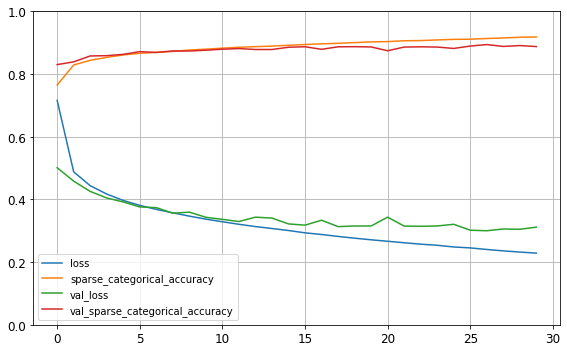

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

##### Evaluate on Test data

In [ ]:
model.evaluate(X_test, y_test) # output [loss, accuracy]

313/313 [==============================] - 0s 1ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.8822


[0.33553507924079895, 0.8822000026702881]

##### Predict
take few intances to predict

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 82ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

predict classes:

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)

print(y_pred)
print(np.array(class_names)[y_pred])

1/1 [==============================] - 0s 18ms/step
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


Saving figure fashion_mnist_images_plot


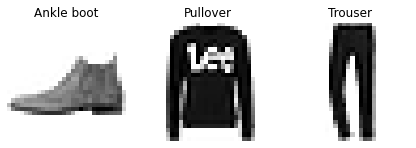

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### Regression MLP using Sequential API
- declarative model i.e. each layer needs to be declared in advance
- single output neutro as we want to predict a value
- no activation function in the output layer is needed
- loss function is MSE

<img src="screenshots/ch_10/2023-01-24-19-46-32.png" width="600px" img/>
<img src="screenshots/ch_10/2023-01-24-19-46-58.png" width="600px" img/>

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2)

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

if the data is noisy like here, use a single layer to prevent overfitting

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

print(y_pred)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 892us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 977us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4875 - val_loss: 0.

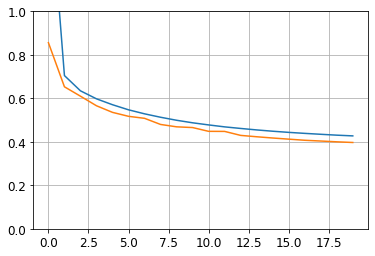

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Complex models with Functional API
- declarative model i.e. each layer needs to be declared in advance
- each layer is a function of some other layer
- can be one or many inputs

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see paper) connects all or part of the inputs directly to the output layer.

<img src="screenshots/ch_10/2023-01-24-19-38-13.png" width="600px" img/>

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_) # hidden1 is a function of input_
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2]) # concatenate is a function of 2+ pior layers
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_40 (Dense)               (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_41 (Dense)               (None, 30)           930         ['dense_40[0][0]']               
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_41[0][0]']           

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4659 - val_loss: 0.4313

##### Deep & Wide model
- more than one input of features, some inputs go Wide path some Deep, some features are in both inputs!
- Wide path - bypasses some layers i.e. go wide off the tree and back to it, skips some layers
- Deep path - goes to most or all layes (deep learning) 
- it allows to learn both deep rules through deep paths (for accuracy) and simple rules through short paths for generalization (to prevent overfitting) (in sequence API all inputs go through all layers, so each input is affected by transformation of each layer - no way to train simple rules)

<img src="screenshots/ch_10/2023-01-24-19-40-01.png" width="600px" img/>

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense_43 (Dense)               (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_44 (Dense)               (None, 30)           930         ['dense_43[0][0]']               
                                                                                            

We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:] # We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315

##### Models with multiple Outputs:
- Reasons for multi onputs: 
-   tasks requires it e.g. we want to locate (regression to find coordinates of the object center) and classify (classification) object in a picture
-   Multiple tasks e.g. Multitask Classification -> identify if person on a picture is smilling AND if they wear glasses (these could be run in 2 separate models, but there maybe some learning that can be intechanged between two taks -> better to run a single network)
-   Learn something from a part of the network only -> one of the outputs get out in the middle of the network
-   Regularization i.e. adding an Axuliary Output somewhere in the middle creates a training contraint, that may reduce overfitting of the ouverall model

<img src="screenshots/ch_10/2023-01-24-19-41-46.png" width="600px" img/>

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2]) # hidden2 is part of the concat function
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2) # hidden2 is also connected to an auxiliary output
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output]) # list both outputs
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense_47 (Dense)               (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_48 (Dense)               (None, 30)           930         ['dense_47[0][0]']               
                                                                                            

In [ ]:
model.compile(loss=["mse", "mse"] # we have two outputs some two loss functions
            , loss_weights=[0.9, 0.1] # by default it will take average of the two loss functions - so pass weights: 90% for main, an 10% for regularization
            , optimizer=keras.optimizers.SGD(learning_rate=1e-3)
            )

In [ ]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train] #need to specify separate Target for each output, here is the same
                    , epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]) # same for validation
                    )

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

- it will return total loss, as well as loss for each output
- prediction will do the same

In [ ]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 65ms/step


### Subclass API to build Dynamic Models
- Sequential and Functional models are declerative - layers and structure is declared before model trains - easy to check, debug,confirm, also save and share the model
- but some solutions require loops, varying shapes, conditional branching, other dynamic behaviours
- another reson is to have more contol over the model
- to do it we need to put Model into class, create layers in constructor, and use them to perform computition in Call() method
- call() - here comes flexibility: we can do if-statement, loops, low-level tensor flow operations etc.
- side-effect -> difficult to tack, cannot save or clone. summary() shows only list of layers, and not how they are connected

Example of the same model as before but with class

In [ ]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # **kwags handles standard args e.g. name
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs): # here comes flexibility: we can do if-statement, loops, low-level tensor flow operations etc.
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

### Saving and restoring model
- Keras uses HDF5 format, stores model architecture, every layer, hyperparameter, weights and biases, also saves optimizer
- altenative is tensorflow SaveModel format
- dynamic subclass - no standard saving. we can use save_weights() and load_weights() to save and restore parms, but everything else needs to solved manually

In [ ]:
model.save("my_keras_model.h5")
# then
model = keras.models.load_model("my_keras_model.h5")
# predict
model.predict(X_new)

# also save weights
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")

### Fit() Callbacks to save incremental outputs
- if models is complex and runs long, or data is very large. what if your comp crashes?
- model fit() accepts Callbacks arg to specify list of objects to call at the beginning and end of training, or each epoch, or even each processing batch 

- example of model "checkpoint_cb" - saves by default at each epoch
- with "save_best_only=True" if will save only if better at this epoch
- will save to the same h5 file as the overall model
- when we load the model at the end - it will load the best model selected from the entire process!

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])  

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 869us/step - loss: 0.4382


### Fit() EarlyStopping to interupt when no sufficent progress
- evalutates after a selected number of epochs,("patience" argument) that will roll back to best model
- we can therefore set at bigger number of epoch to train
- we can combine callbacks to Save (pevent comp crashes) and Earlystopping (to not to waste time)
- there are many other callback functions... keras.collbacks

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

##### Define custom callback
- e.g. to calculate ratio of validation loss over training loss during training (below) or other debugging
- callbacks can be implemented during:
    - training: on_train_begin(), on_train_end(),on_epoch_begin(), on_epoch_end(),on_batch_begin(), on_batch_end()
    - evaluation "evaluate(...)": on_test_begin(), on_test_end(),on_test_batch_begin(), on_test_batch_end()
    - prediction "predict(...)": on_predict_begin(), on_predict_end(),on_predict_batch_begin(), on_predict_batch_end()

Example: custom callback to calculate ratio of validation loss over training loss during training

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

344/363 [===========================>..] - ETA: 0s - loss: 0.4362
val/train: 0.94
363/363 [==============================] - 1s 1ms/step - loss: 0.4393 - val_loss: 0.4110


### Tensor Board
- great to visualize and analyze models
- installed automatically with ts

we need to modify output of the model to special binary folder called "event files". Each binary data record is called "summary". TensorBoard will monitor the directory and update viz if changes. 
We want to point TensorFlow to a root log directory, and then have a separate subdirectory per model each time it runs, so that we can compare models 

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2022_08_30-14_21_01'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Keras provides TensorBoard() callback

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 2.5064 - val_loss: 1.3439
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8663 - val_loss: 0.7511
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.7497 - val_loss: 0.6723
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6860 - val_loss: 0.6252
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6417 - val_loss: 0.5836
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6052 - val_loss: 0.5526
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5760 - val_loss: 0.5254
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5505 - val_loss: 0.5023
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.4826
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5097 - val_loss: 0.4658

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

$ tensorboard --logdir=./my_logs --port=6006

You can then open your web browser to localhost:6006 and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [116]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Check out the other available logging options:

In [103]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



### Hyperparameters tuning

##### Nbr of hidden layers:
- even one layer is good, but it requires a lot of neutrons. more efficent to have few hidden layers with less neutrons
- real-world data is often build hierarchically to favor more layers e.g. low-level focuses on segments of shapes, mid-level combines low-level into shapes e.g. squares and circles, and high-level and output layers combine low and hid layers into high level structures such as faces
- if we want to model hair styles on faces- no need to start from scratch. we can assign weights from a lower layer model that already model faces ("transfer learning")
- some complex problems require hundreds of layers e.g. speach recognition. but some layers are not connected fully, some leverage other prior learnings that were done at more rudminetary level
- too many layers will hower overfit!

##### Nbr of neutrons per hidden layer:
- 

##### Parms optimization options:
- https://github.com/hyperopt/hyperopt
- https://github.com/maxpumperla/hyperas
- https://github.com/Avsecz/kopt
- https://github.com/autonomio/talos
- https://www.youtube.com/watch?v=Un0JDL3i5Hg&t=24s
- https://scikit-optimize.github.io/stable/
- https://github.com/JasperSnoek/spearmint
- https://github.com/zygmuntz/hyperband
- https://github.com/rsteca/sklearn-deap

##### Optimization APIs:
- https://cloud.google.com/ai-platform/training/docs/using-hyperparameter-tuning
- https://arimo.com/
- https://sigopt.com/
- http://oscar.calldesk.ai/
- https://cloud.google.com/automl/

#### Interesting papers
- https://arxiv.org/abs/1603.06560
- https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html
- https://www.uber.com/blog/deep-neuroevolution/


##### Example of how to wrap model into scikit_learn wrapper to grid search or randomsearch for parms

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

put model into a def

In [7]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

wrap with scikit_learn

In [8]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


execute for one parm setting

In [13]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4060 - val_l

In [14]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3412


In [15]:
y_pred = keras_reg.predict(X_new)

NameError: name 'X_new' is not defined

##### apply RandomizedSearchCV

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [========

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x156f1cef0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112298,
                                                          0.0...
            

In [20]:
print("rnd_search_cv.best_params_",rnd_search_cv.best_params_)
print("rnd_search_cv.best_score_",rnd_search_cv.best_score_)
print("rnd_search_cv.best_estimator_",rnd_search_cv.best_estimator_)
print("rnd_search_cv.score(X_test, y_test)",rnd_search_cv.score(X_test, y_test))

model = rnd_search_cv.best_estimator_.model
model

rnd_search_cv.best_params_ {'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}
rnd_search_cv.best_score_ -0.31833014885584515
rnd_search_cv.best_estimator_ <keras.wrappers.scikit_learn.KerasRegressor object at 0x15b88d630>
162/162 [==============================] - 0s 1ms/step - loss: 0.3029
rnd_search_cv.score(X_test, y_test) -0.30288204550743103


In [21]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3029


0.30288204550743103